# Реализация логистической регрессии в TensorFlow

ДАНИЛЬЧЕНКО ВАДИМ

In [1]:
import numpy as np
import tensorflow as tf
import warnings

warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt

## Генерируем данные для задачи регрессии

In [3]:
NUM_FEATURES = 2
NUM_SAMPLES = 1000

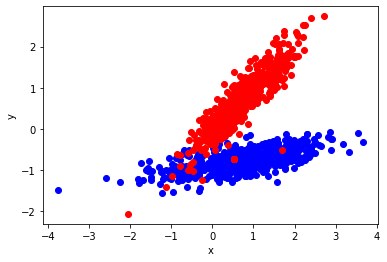

In [4]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples = NUM_SAMPLES,
                           n_features = NUM_FEATURES,
                           n_informative = NUM_FEATURES,
                           n_redundant = 0,
                           n_classes = 2,
                           n_clusters_per_class = 1,
                           class_sep = 0.75,
                           random_state = 54312)

y = y.reshape(-1, 1)

ones = np.where(y == 1)   # индексы объектов класса '1'
zeros = np.where(y == 0)  # индексы объектов класса '0'

plt.xlabel('x')
plt.ylabel('y')
plt.plot(X[ones, 0], X[ones, 1], 'ob',
         X[zeros, 0], X[zeros, 1], 'or');

## Вспомогательная функция для создания операций

In [5]:
import string

def py_func_with_grad(func, inp, Tout, grad, name = None, stateful = False, graph = None):
    
    name_prefix = ''.join(np.random.choice(list(string.ascii_letters), size = 10)) # генерит новое имя
    
    name = '%s_%s' % (name_prefix, name or '') 
    grad_func_name = '%s_grad' % name # к имени из 10 букв пребавляет '_grad'
    
    # декоратор для регистрации функции градиента для типа op
    tf.RegisterGradient(grad_func_name)(grad) 

    # оборачиваем нашу функцию в качестве тензора
    g = graph or tf.get_default_graph()
    with g.gradient_override_map({'PyFunc': grad_func_name, 
                                  'PyFuncStateless': grad_func_name}):
        with tf.name_scope(name, 'PyFuncOp', inp):
            return tf.py_func(func, inp, Tout, stateful = stateful, name = name)

## Реализация линейной операции

In [6]:
def linear_op_forward(X, W, bias):
    ''' Реализация линейной операции '''
    return np.dot(X, W.T)+ bias  # аргументы являются numpy-массивами

def linear_op_backward(op, grads):
    ''' Реализация вычисления градиента линейной операции '''
    X = op.inputs[0]  # тензор входных данных
    W = op.inputs[1]  # тензор параметров модели
    bias=op.inputs[2]
    dX = tf.multiply(grads, W)
    dW = tf.reduce_sum(tf.multiply(X, grads),
                       axis = 0,
                       keepdims = True)
    dbias = tf.reduce_sum(tf.multiply(1., grads),
                      axis = 0,
                      keepdims = True)
    return dX, dW, dbias

def sigmoid_op_forward(X):
    # TODO: реализовать операцию sigmoid
    return 1/(1+np.e**(-X))

def sigmoid_op_backward(op, grads):
    # TODO: реализовать вычисление градиента для sigmoid
    sigmoid = op.outputs[0]  
    dsigm=sigmoid * (1 - sigmoid)
    dgrad = tf.reduce_sum(tf.multiply(dsigm, grads),
                       axis = 0,
                       keepdims = True)
    return dgrad

## Создание графа вычислений и обучение модели

In [24]:
BATCH_SIZE = NUM_SAMPLES // 10

weights = None  # в этой переменной мы сохраним результат обучения модели
learning_curve = []  # значения ошибки на каждой итерации обучения
bias=None

with tf.Session(graph = tf.Graph()) as sess:  # инициализируем сессию вычислений
    
    # создаем placeholdr'ы, через них мы будем
    # передавать внешние данные в граф вычислений
    plh_X = tf.placeholder(dtype = tf.float32, shape = [None, NUM_FEATURES])
    plh_labels = tf.placeholder(dtype = tf.float32, shape = [None, 1])

    # создаем переменную для хранения весов модели
    # эти веса будут изменяться в процессе обучения
    var_W = tf.Variable(tf.random_uniform(shape = [1, NUM_FEATURES],
                                          dtype = tf.float32,
                                          seed = 777))
    # bias
    var_bias = tf.Variable(tf.random_normal(shape = [1, 1], 
                                         mean = 0.5, 
                                         dtype = tf.float32, 
                                         seed = 777))
    # создаем переменную для результата предсказания модели
    var_Pred = py_func_with_grad(linear_op_forward,         # функция предсказания модели 
                                 [plh_X, var_W, var_bias],  # аргументы функции
                                 [tf.float32],              # тип выходных значений
                                 name = 'linear_op',        # имя операции 
                                 grad = linear_op_backward, # функция для вычисления градиента
                                 graph = sess.graph)        # объект графа вчислений
    
    # создаем переменную для результата операции sigmoid
    var_Sigmoid = py_func_with_grad(sigmoid_op_forward,
                                    [var_Pred],
                                    [tf.float32],
                                    name = 'sigmoid_op',
                                    grad = sigmoid_op_backward,
                                    graph = sess.graph)
    
    # кроссэнтропийная функция потерь для бинарной классификации
    cost = tf.losses.sigmoid_cross_entropy(plh_labels, var_Sigmoid)
    
    # инициализируем оптимизатор и указываем скорость обучения
    optimizer = tf.train.GradientDescentOptimizer(learning_rate = 0.5).minimize(cost)

    # инициализируем placeholder'ы и переменные
    sess.run(tf.global_variables_initializer())
    
    indices = np.arange(len(X))  # массив индексов объектов
    
    # выполняем итерации по эпохам
    for epoch in range(500):
        
        # вначале каждой эпохи перемешиваем индексы
        np.random.shuffle(indices)
        
        # внутри каждой эпохи данные разбиваются на батчи
        for batch in range(len(X) // BATCH_SIZE):
            
            # выбираем индексы очередного батча
            batch_indices = indices[batch * BATCH_SIZE:(batch + 1) * BATCH_SIZE]

            # выполняем шаг обучения: вычисляем ошибку и обновляем веса
            loss, _ = sess.run([cost, optimizer],  # указываем, какие операции необходимо выполнить
                               feed_dict = {plh_X: X[batch_indices],  # передаем входные данные для вычисления
                                            plh_labels: y[batch_indices]})
        
            # сохраняем занчения ошибки для построения кривой обучения
            learning_curve.append(loss)
            
            # выводим текущее значение ошибки для каждого 10го шага
            steps = len(learning_curve) - 1
            if steps % 200 == 0:
                print('[%03d] loss=%.3f weights=%s bias=%s' % (steps, loss, var_W.eval(), var_bias.eval()))
    
    # сохраняем обученные веса
    weights = var_W.eval()
    bias=var_bias.eval()

[000] loss=0.771 weights=[[0.7983845  0.54528284]] bias=[[0.188898]]
[200] loss=0.599 weights=[[ 0.6999344 -3.210965 ]] bias=[[-1.018537]]
[400] loss=0.540 weights=[[ 1.0582627 -4.2899723]] bias=[[-1.4973357]]
[600] loss=0.518 weights=[[ 1.2858983 -4.975011 ]] bias=[[-1.8293879]]
[800] loss=0.531 weights=[[ 1.4468083 -5.4924483]] bias=[[-2.083684]]
[1000] loss=0.512 weights=[[ 1.565513  -5.9189663]] bias=[[-2.2848802]]
[1200] loss=0.552 weights=[[ 1.6648943 -6.2789974]] bias=[[-2.4596958]]
[1400] loss=0.552 weights=[[ 1.7440706 -6.597562 ]] bias=[[-2.6057246]]
[1600] loss=0.557 weights=[[ 1.8157381 -6.8788757]] bias=[[-2.7406292]]
[1800] loss=0.499 weights=[[ 1.8776472 -7.136605 ]] bias=[[-2.8566628]]
[2000] loss=0.527 weights=[[ 1.9326583 -7.3698936]] bias=[[-2.9692464]]
[2200] loss=0.526 weights=[[ 1.9805545 -7.586885 ]] bias=[[-3.0699754]]
[2400] loss=0.555 weights=[[ 2.027379 -7.788201]] bias=[[-3.1637797]]
[2600] loss=0.502 weights=[[ 2.070667  -7.9773397]] bias=[[-3.250015]]
[280

## Визуализируем кривую обучения

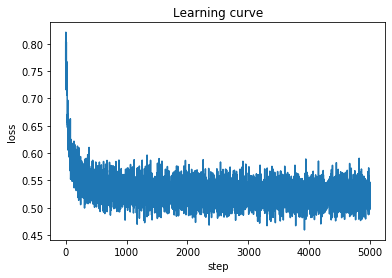

In [25]:
plt.xlabel('step')
plt.ylabel('loss')
plt.title('Learning curve')
plt.plot(learning_curve);

## Визуализируем разделяющую гиперплоскость

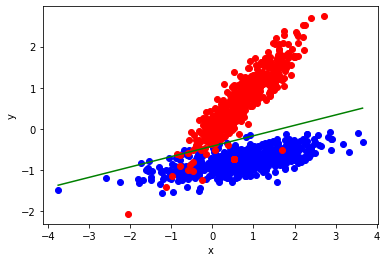

In [26]:
y_pred = - X[:, 0] * weights[0, 0]/weights[0, 1] - bias[0, 0]/ weights[0, 1]

order = np.argsort(X[:, 0])

plt.xlabel('x')
plt.ylabel('y')
plt.plot(X[ones, 0], X[ones, 1], 'ob',
         X[zeros, 0], X[zeros, 1], 'or',
         X[order, 0], y_pred[order], '-g');